<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

In [135]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [136]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.7.0+cpu


## 1. What are 3 areas in industry where computer vision is currently being used?

1. Automotive cars
2. Analyzing image data in medicine (CT, MRT, etc.)
3. Face recognition for CCTV cameras

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting happens when the model is predicting well on the training data but bad on the test data. This happens when the model is too comples, i.e there are too many parameters and hidden layers. In such a case, outliers are getting way too much attention and therefore the model performs worse near those outliers.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

**Early Stopping**
- Monitor the performance of the model on the test data during training. 
- When the performance starts to worsen, stop the training process, no matter if the training is done or not. 
- However, this technique can lead to underfitting if the training process was stopped too early.

**K-Fold Cross-Validation**
- Split the dataset into the number of k-folds.
- Start off by using the k-1 fold as the test dataset and the remaining folds as the training dataset.
- Train the model on the training dataset and validate on the test dataset.
- Save the validation score.
- Repeat steps 3 - 5, but change the value of your k-test dataset. So we choose k-1 as our test dataset for the first round, then k-2 for the second round ...
- By the end of it you would have validated the model on every fold that you have.
- Average the results you produced in step 5 to summarize the skill of the model.

**Dropout**
Dropping out the nodes (input and hidden layer) in a neural network. All the forward and backward connections with a dropped node are temporarily removed (only in training), thus creating a neural network architecture out of the parent network. The nodes are dropped by a dropout probability of p.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [137]:
import torchvision
from torchvision import datasets

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

class_names = train_data.classes

## 6. Visualize at least 5 different samples of the MNIST training dataset.

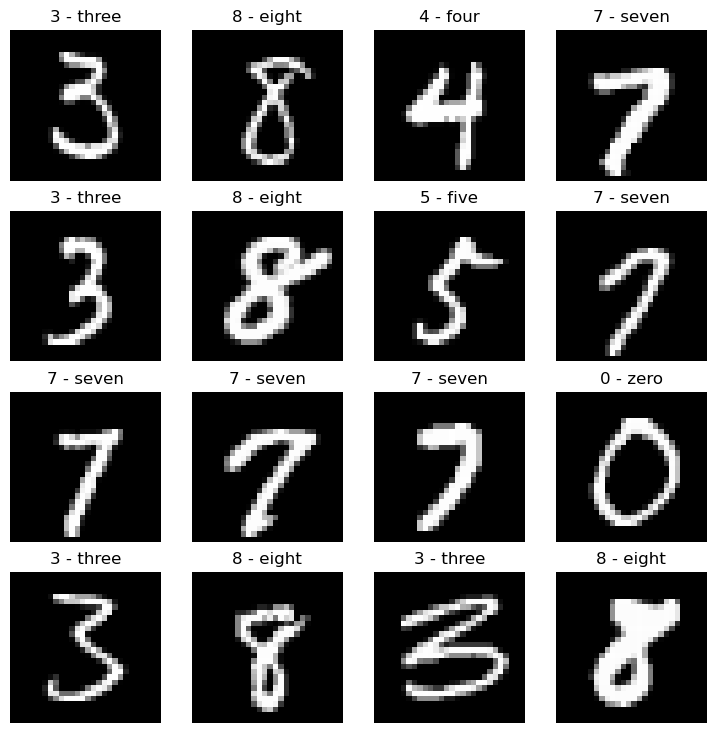

In [138]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [189]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of the test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x74e40620e330>, <torch.utils.data.dataloader.DataLoader object at 0x74e3de95a0f0>)
Length of the train_dataloader: 1875 batches of 32...
Length of the test_dataloader: 313 batches of 32


In [190]:
img, label = train_data[0]
img.shape

torch.Size([1, 28, 28])

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [191]:
from torch import nn
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

class MNISTModelV0(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN Explainer website"""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*49,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
    
mnist_model = MNISTModelV0(input_shape=1,
                           hidden_units=10,
                           output_shape=len(class_names))

In [192]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_model.parameters(), lr=0.1)

In [193]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0

    model.eval()

    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [194]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manageer
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [195]:
from timeit import default_timer as timer

epochs = 3
train_time_start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")

    train_step(mnist_model, train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    test_step(mnist_model, test_dataloader, loss_fn=loss_fn, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.24489 | Train acc: 92.17%
Test loss: 0.06704 | Test acc: 97.89%

Epoch: 1
----------
Train loss: 0.06875 | Train acc: 97.90%
Test loss: 0.04810 | Test acc: 98.28%

Epoch: 2
----------
Train loss: 0.05417 | Train acc: 98.30%
Test loss: 0.04968 | Test acc: 98.31%



## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [196]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [197]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# Make predictions
pred_probs = make_predictions(mnist_model, test_samples, device)

# Convert prediction probabilities to label
pred_classes = pred_probs.argmax(dim=1)

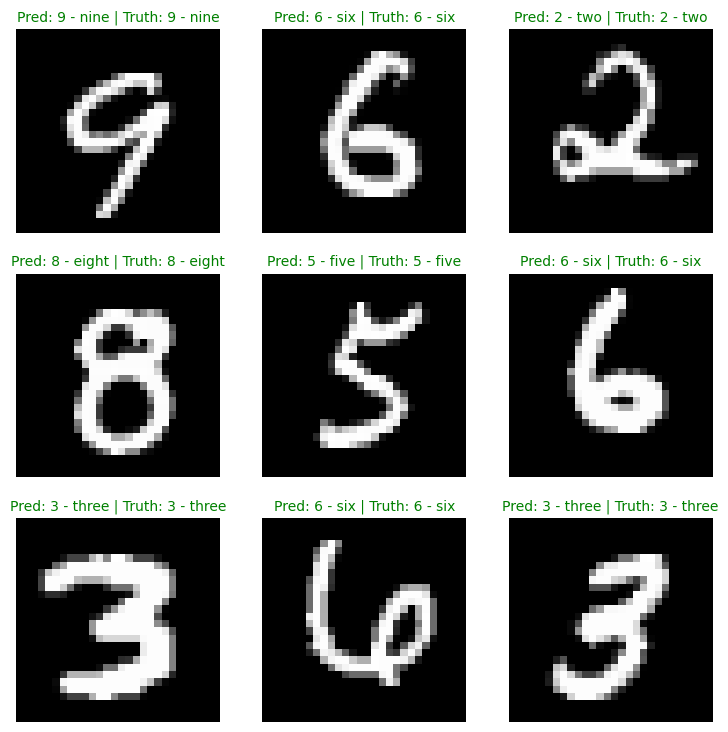

In [198]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [199]:
# 1. Make predictions with our trained model on the test dataset
y_preds = []
mnist_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and targets to target device
        X, y = X.to(device), y.to(device)
        
        # Do the forward pass
        y_logits = mnist_model(X)

        # Turn the logits into a label
        y_pred = y_logits.argmax(dim=1)

        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
len(y_pred_tensor)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

10000

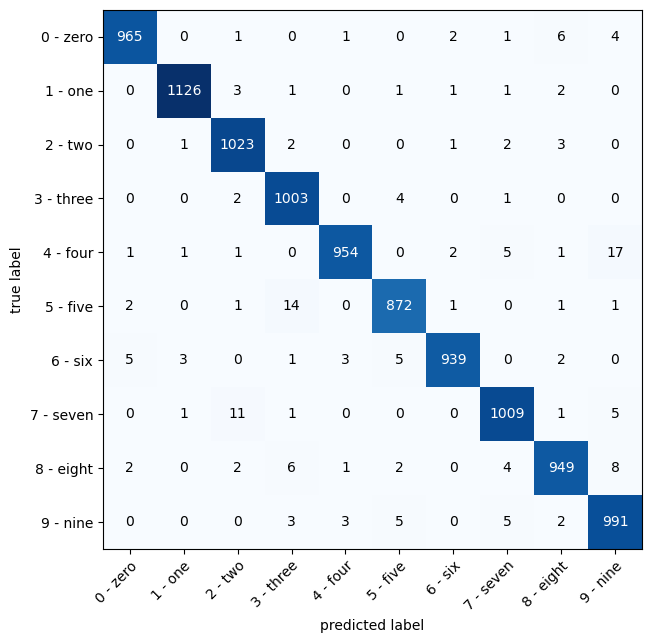

In [201]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot our confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)